In [1]:
import pandas as pd   # manipulatcion y analisis de dataframes
import numpy as np  # operaciones matematicas y logicas
import matplotlib.pyplot as plt  # visualizacion de datos
import seaborn as sns # visualizacion de datos estadisticos
from scipy.stats import norm # distribuciones de probabilidad y estadistica

In [2]:
inventario = pd.read_excel("dataset/archivo_actualizado.xlsx")

In [3]:
#Limpieza columnas inutiles
inventario.drop(columns=['Unnamed: 0'], inplace=True)

# 1.Identificación de variables relevantes para estimar el inventario ideal
Para construir un modelo de inventario ideal, se consideran variables cuantitativas y cualitativas que reflejan el comportamiento de la demanda, la criticidad del producto y la confiabilidad de los datos. A continuación, se listan y justifican:

## Variables cuantitativas

* Demanda promedio mensual
Refleja la cantidad promedio vendida por mes. Es la base para estimar el consumo esperado y calcular el stock necesario.

* Desviación estándar de la demanda
Mide la variabilidad en la demanda. Es esencial para calcular el inventario de seguridad que cubre incertidumbre.

* Costo unitario
Permite priorizar productos en función de su impacto financiero. Ayuda a aplicar políticas diferenciadas de inventario (por ejemplo, stock mínimo más bajo para productos costosos).

* Ventas totales
Ayuda a identificar productos de alto impacto económico, útiles para análisis tipo ABC o decisiones estratégicas de stock.


## Variables cualitativas

* Validez del producto (SKU válido)
Se validó previamente la estructura del código SKU para asegurar que los productos considerados sean reales y operativos.

* Estado del costo (costo válido/sospechoso)
Se filtraron los productos con valores de costo irrealmente bajos, los cuales podrían distorsionar el modelo.

* Rotación (historial de ventas)
Se excluyeron productos sin ventas en el período analizado, ya que no permiten estimar demanda ni justificar stock.


In [4]:
meses = ["enero", "febrero", "marzo", "abril", "mayo", "junio",
         "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"]

inventario["demanda_promedio"] = inventario[meses].mean(axis=1)



In [5]:
#Desviacion estandas de la demanda
inventario["desviacion_demanda"] = inventario[meses].std(axis=1)


In [6]:
inventario.describe()

,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,costo_unitario,cantidad_vendidos,ventas_totales,demanda_promedio,desviacion_demanda
count,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2.453000e+03,2453.000000,2.453000e+03,2453.000000,2453.000000
mean,19.749694,22.366490,17.991847,23.662862,19.801468,18.710151,20.710558,21.680799,20.068080,25.757848,20.090094,20.225846,6.308420e+04,250.815736,7.933299e+06,20.901311,9.929443
std,72.879653,77.401739,60.769917,88.404417,66.653056,62.784410,68.853458,74.891060,68.909904,108.284122,65.497317,65.855869,1.307003e+05,834.546798,2.208344e+07,69.545566,26.238987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,1.000000e+00,0.083333,0.288675
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.828268e+04,4.000000,2.142174e+05,0.333333,0.797724
50%,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.550827e+04,28.000000,1.217695e+06,2.333333,2.632835
75%,10.000000,11.000000,10.000000,13.000000,11.000000,11.000000,12.000000,12.000000,12.000000,15.000000,11.000000,11.000000,7.204790e+04,157.000000,5.675545e+06,13.083333,8.932406
max,1525.000000,1431.000000,934.000000,2195.000000,1194.000000,1077.000000,1094.000000,1389.000000,1107.000000,2797.000000,964.000000,1034.000000,3.542826e+06,16709.000000,3.459247e+08,1392.416667,563.326235


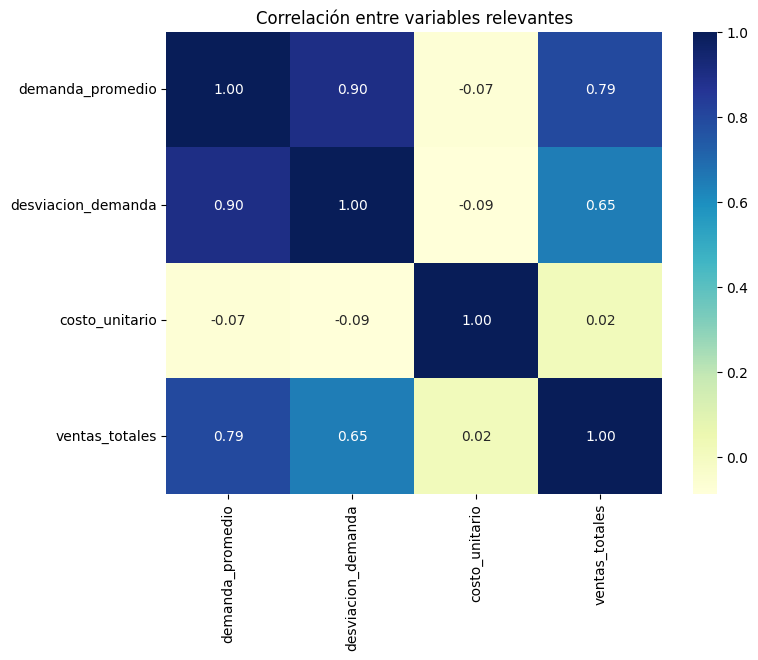

In [7]:
variables_p1 = ["demanda_promedio", "desviacion_demanda", "costo_unitario", "ventas_totales"]

plt.figure(figsize=(8, 6))
sns.heatmap(inventario[variables_p1].corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlación entre variables relevantes")
plt.show()

Se verifican las fuertes correlaciones entre la demanda promedio y la desviacion estandar , lo cual es logico entre mas rotan mayor sera su variabilidad.

Se refleja como el tam del costo unitario tiene una baja relacion con las demas variables dado que esta caracteristica es util para analisis financieros por ejemplo pero no esta directamente relacionado con la demanda.

Esta grafica valida la inclusion de las variables mencionadas para estimar el inventario ideal por su SKU

## 2. Propuesta de modelo de inventario ideal y justificación

Para estimar el inventario ideal por SKU, se utilizó un modelo clásico basado en la fórmula:

> **Inventario ideal = Demanda promedio mensual + Inventario de seguridad**

El inventario de seguridad se calcula a partir de la **desviación estándar de la demanda**, considerando un nivel de servicio deseado del **95%**, lo cual corresponde a un valor Z = 1.65 en una distribución normal estándar. Dado que el lead time (tiempo de reabastecimiento) no fue proporcionado, se asumió un **lead time de 1 mes**.

La fórmula completa aplicada fue:



- **Demanda distribuida normalmente**, según el histórico mensual.
- **Lead Time = 1 mes**, asumido por simplicidad.
- **Nivel de servicio objetivo = 95%**, aplicando un Z = 1.65.
- Los productos **sin ventas** fueron excluidos previamente del análisis, dado que no se puede estimar una demanda futura ni aplicar inventario objetivo.
- Se utilizan columnas generadas en el análisis exploratorio: `demanda_promedio` y `desviacion_demanda`. 

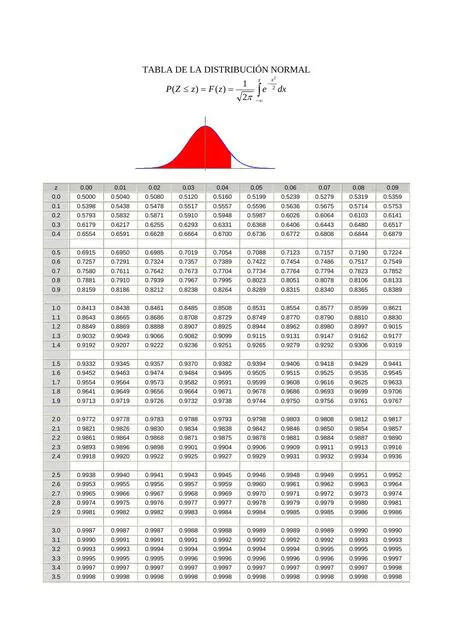

In [8]:
Z = 1.65
LT = 1

inventario["inventario_ideal"] = inventario["demanda_promedio"] + Z * inventario["desviacion_demanda"] * (LT ** 0.5)


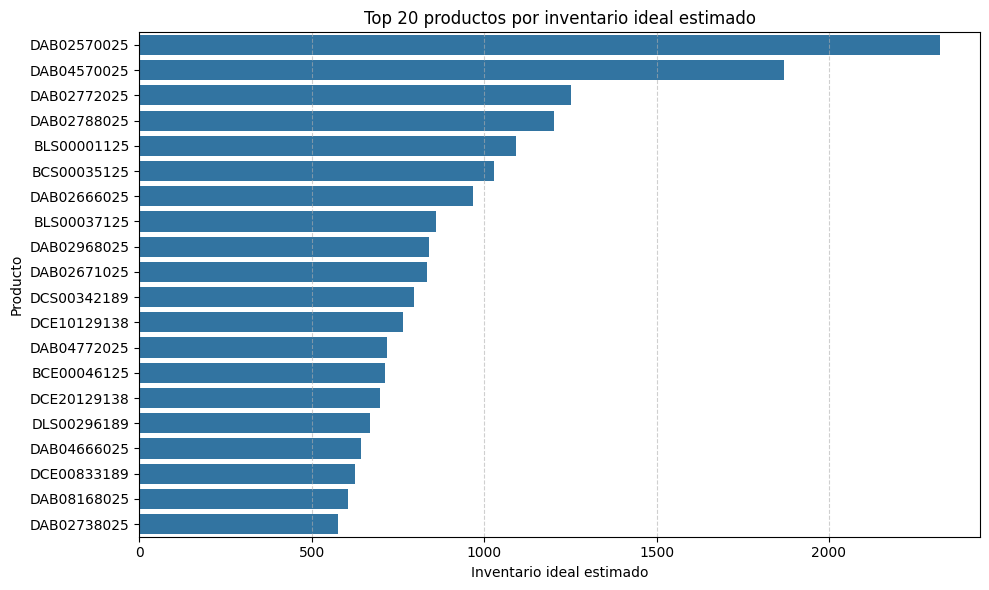

In [9]:
top_inv = inventario.sort_values("inventario_ideal", ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_inv,
    x="inventario_ideal",
    y="producto"
)
plt.title("Top 20 productos por inventario ideal estimado")
plt.xlabel("Inventario ideal estimado")
plt.ylabel("Producto")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Los productos que requieren mayor inventario ideal corresponden a aquellos con alta demanda y/o alta variabilidad. Esto sugiere priorizar su disponibilidad operativa.

## 3. Estimación del nivel de servicio alcanzado


El nivel de servicio representa la **probabilidad de tener disponible un producto cuando el cliente lo solicita**. Para calcularlo, se utilizó el modelo de inventario ideal propuesto en el punto anterior como referencia de stock.

Dado que no se cuenta con datos reales de inventario disponible, se asumió que el **inventario actual es igual al inventario ideal**, lo cual corresponde a un escenario donde la empresa ha logrado implementar las políticas de stock propuestas.

Para cada producto, se aplicó la fórmula:

Supuestos clave:
- **El inventario actual = inventario ideal**   Dado que no tenemos inventario incial
- La demanda sigue una distribución normal
- Se prioriza una cobertura del 95% de las solicitudes

In [10]:
inventario['inventario_actual'] = inventario['inventario_ideal']

In [11]:
# Calculo nivel de servicio
inventario["nivel_servicio"] = norm.cdf(
    inventario["inventario_actual"],
    loc=inventario["demanda_promedio"],
    scale=inventario["desviacion_demanda"]
)

In [12]:
inventario["nivel_servicio"].describe()

count    2.453000e+03
mean     9.505285e-01
std      8.683516e-18
min      9.505285e-01
25%      9.505285e-01
50%      9.505285e-01
75%      9.505285e-01
max      9.505285e-01
Name: nivel_servicio, dtype: float64

El nivel de servicio teórico para todos los productos es de 95.05%, dado que se asumió un inventario ajustado al ideal. Esto representa un escenario óptimo donde se espera alta disponibilidad si se implementa esta política

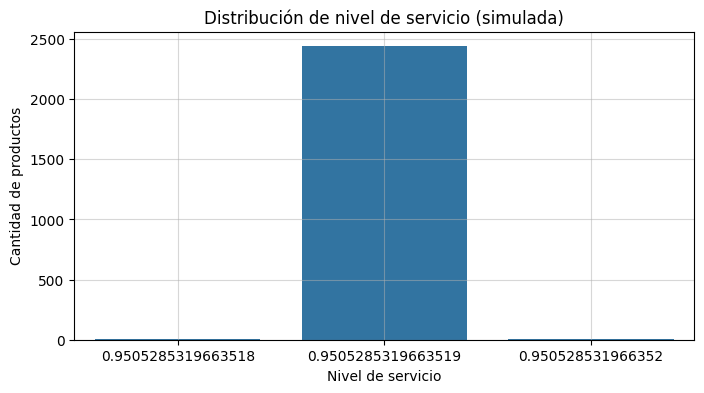

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(x=inventario["nivel_servicio"])
plt.grid(True,alpha=0.5)
plt.title("Distribución de nivel de servicio (simulada)")
plt.xlabel("Nivel de servicio")
plt.ylabel("Cantidad de productos")
plt.show()

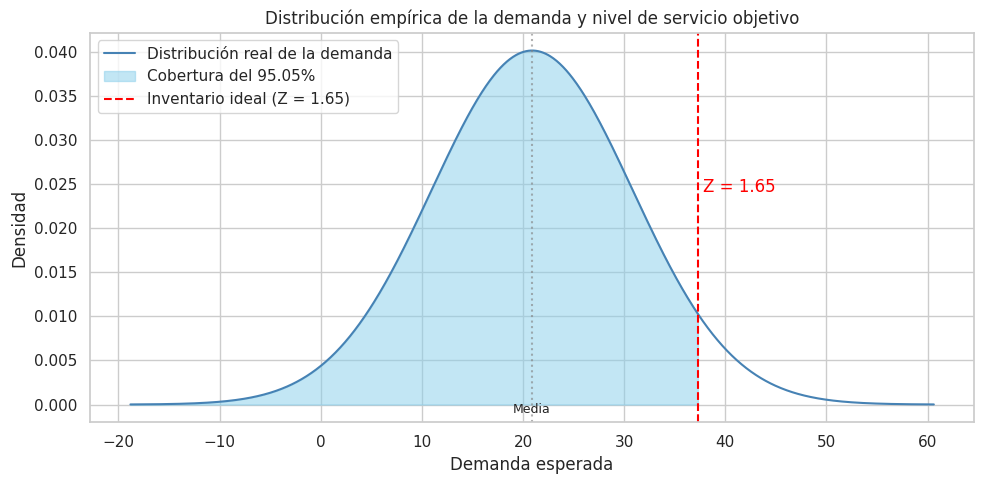

In [14]:
mu = inventario["demanda_promedio"].mean()
sigma = inventario["desviacion_demanda"].mean()
z_val = Z
nivel_servicio = mu + z_val * sigma

# Eje X centrado alrededor de la media real
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)

# Crear gráfico
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

# Curva normal
plt.plot(x, y, label="Distribución real de la demanda", color="steelblue")

# Rellenar hasta nivel de servicio
x_fill = np.linspace(mu - 4*sigma, nivel_servicio, 500)
y_fill = norm.pdf(x_fill, mu, sigma)
plt.fill_between(x_fill, y_fill, color="skyblue", alpha=0.5, label=f"Cobertura del 95.05%")

# Línea roja en nivel de servicio
plt.axvline(nivel_servicio, color="red", linestyle="--", label=f"Inventario ideal (Z = 1.65)")
plt.text(nivel_servicio + sigma * 0.05, max(y) * 0.6, "Z = 1.65", color="red")

# Opcional: línea en la media
plt.axvline(mu, color="gray", linestyle=":", alpha=0.6)
plt.text(mu, -0.001, "Media", ha="center", fontsize=9)

# Títulos
plt.title("Distribución empírica de la demanda y nivel de servicio objetivo")
plt.xlabel("Demanda esperada")
plt.ylabel("Densidad")
plt.legend()
plt.tight_layout()
plt.show()



Se calculó el nivel de servicio estimado para cada SKU utilizando la fórmula basada en la distribución normal:

> `Nivel de servicio = P(X ≤ Inventario actual)`

Bajo el supuesto de que la empresa cuenta con un inventario **ajustado al nivel ideal propuesto** (ver Punto 2), se obtuvo un **nivel de servicio constante de 95.05%** en todos los productos, correspondiente a un valor Z = 1.65.

Esta configuración representa un escenario óptimo desde el punto de vista logístico, donde se espera que **la empresa tenga inventario disponible en el 95% de los casos** al momento de una solicitud.

La visualización confirma este comportamiento: todos los productos muestran el mismo nivel de servicio, dado que el inventario fue definido directamente por la fórmula ideal propuesta.

> En un escenario real, este análisis permitiría detectar productos con nivel de servicio bajo y diseñar estrategias de abastecimiento más precisas.

## Conclusiones y recomendaciones generales




Durante el análisis del inventario histórico de filtros se realizaron procesos de limpieza, transformación y evaluación analítica orientados a proponer un modelo de inventario ideal y estimar el nivel de servicio. A continuación se resumen los principales hallazgos y recomendaciones:

---

### Exploración y limpieza de datos (EDA)

- **Errores en unidades vendidas:** Se identificaron valores negativos en las ventas mensuales, los cuales fueron corregidos por ser inconsistentes con la lógica de ventas reales.

- **Anomalías en códigos SKU:** Se detectó una mezcla de formatos en la columna `producto`, incluyendo errores de digitación y registros no válidos (e.g., `"FILTROS PARA MUESTRA COMERCIAL"`, `"SERV11"`, `"ENERGÍA ELÉCTRICA"`). Estos fueron eliminados para garantizar la consistencia del análisis.

- **Costos unitarios sospechosos:** Algunos productos presentaban un `costo_unitario` extremadamente bajo (incluso igual a $1), inconsistente con los precios del mercado. Para estos casos, se construyó un **dataframe de productos sospechosos**, que se recomienda enviar a los equipos de **contabilidad o ventas** para su revisión y validación.

- **Productos sin rotación:** Se identificaron más de 2.200 productos sin ventas durante el último año. Se recomienda analizar si estos productos deben ser descontinuados, promocionados o ajustados en inventario para evitar costos de almacenamiento innecesarios.

---

### Modelado de inventario y análisis estratégico

- **Modelo de inventario ideal:** Se utilizó una fórmula basada en la distribución normal para calcular el inventario óptimo por SKU. Esto permite cubrir la demanda mensual esperada con un nivel de servicio del 95%, considerando la variabilidad en las ventas.

- **Nivel de servicio estimado:** Bajo el modelo propuesto, todos los productos alcanzarían un nivel de servicio teórico de ~95%, ideal para operaciones que requieren alta disponibilidad. Se sugiere usar esta métrica como base para monitoreo continuo.

- **Clasificación ABC (Pareto):** Se construyó una curva de Pareto que reveló que el **16% de los productos representan el 80% de las ventas**. Esta información permite implementar una política de inventario tipo **ABC**, donde los productos “A” tengan mayor control y prioridad de stock.

---

##  Recomendaciones generales

1. **Auditar y depurar SKUs no válidos**: Mantener una estructura estandarizada evita errores en análisis y en operaciones logísticas.
2. **Crear alertas automáticas de costos sospechosos**, con base en valores de mercado y márgenes.
3. **Implementar inventarios diferenciados** por criticidad del producto (modelo ABC).
4. **Establecer un proceso de revisión periódica** para productos sin rotación.
5. **Automatizar el cálculo de inventario ideal y nivel de servicio**, integrándolo a un dashboard gerencial o sistema ERP.

---

Este análisis proporciona un marco sólido para tomar decisiones informadas que mejoren la eficiencia del inventario, reduzcan quiebres de stock y optimicen los costos de operación.

